In [1]:
import numpy as np
import torch.distributions as distrib
import torch.distributions.transforms as transform
from matplotlib import pyplot as plt
import torch
from torch.autograd import Variable
from torch import optim
from torch import nn

In [2]:
def sample_boom(batch_size):
    x2_dist = distrib.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample((batch_size,))
    x1 = distrib.Normal(loc=.25 * torch.square(x2_samples), scale=torch.ones(batch_size, dtype=torch.float32))
    x1_samples = x1.sample()
    return torch.stack([x1_samples, x2_samples], axis=1)

In [101]:
class LeakyReLU(nn.Module):
    
    def __init__(self, alpha=1.0, validate_args=False, name="leaky_relu"):
        super().__init__()
        
        self.alpha = nn.Parameter(torch.tensor([float(alpha)]), requires_grad=True)
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)

    def forward(self, x):
        return torch.where(torch.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return torch.where(torch.greater_equal(y, 0), y, 1. / self.alpha * y)

    def inv_log_abs_det_jacobian(self, y):
        I = torch.ones_like(y)
        J_inv = torch.where(torch.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        ILDT = torch.log(torch.abs(J_inv))
        return ILDT.sum(axis=-1)

class AffineTrans(nn.Module):
    
    def __init__(self, loc=0.0, scale=1.0, validate_args=False, name="affine_trans"):
        super().__init__()
        
        self.loc = nn.Parameter(torch.tensor([float(loc)]), requires_grad=True)
        self.scale = nn.Parameter(torch.tensor([float(scale)]), requires_grad=True)
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
        
    def forward(self, x):
        return x * self.scale + self.loc
    
    def _inverse(self, y):
        return (y-self.loc) / self.scale
    
    def inv_log_abs_det_jacobian(self, y):
        I = torch.ones_like(y)
        J_inv = 1.0 / self.scale * I
        # abs is actually redundant here, since this det Jacobian is > 0
        ILDT = torch.log(torch.abs(J_inv))
        return ILDT.sum(axis=-1)

In [121]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, base_density):
        super().__init__()
        
        self.layers = []
        
        for i in range(flow_length):
            self.layers.append(AffineTrans())
            self.layers.append(LeakyReLU())
            
        self.base_density = base_density

    # evaluate the log Py(y), given log Px(f.inv(y))log|det(f.inv/dy)|    
    def forward(self, y):
        
        yt = y
        sum_of_det = 0
        
        for l in self.layers:
            yt = l._inverse(yt)
            sum_of_det += l.inv_log_abs_det_jacobian(yt)
    
        x = yt
        log_prob_y_under_x = torch.sum(- (x ** 2) / 2 - np.log(np.sqrt(2 * np.pi)), -1)
        
        return log_prob_y_under_x + sum_of_det
    
    def reverse(self, x):
        
        for l in self.layers:
            x = l(x)
        
        return x
    
# Create normalizing flow
base_density = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

flow = NormalizingFlow(dim=2, flow_length=1, base_density=base_density)

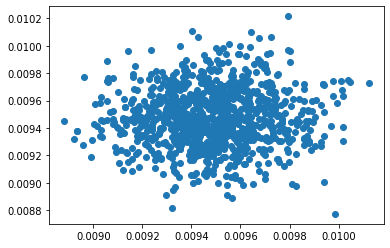

In [115]:
samples = base_density.sample((1000,))
py = flow.reverse(samples).detach().numpy()
plt.scatter(py[:,0], py[:,1])

In [122]:
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

ValueError: optimizer got an empty parameter list

In [123]:
# Main optimization loop
for it in range(100001):
    # Draw a sample batch from target distribution
    boom_samples = sample_boom(512)

    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss = -flow.forward(boom_samples).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss.item()))
        # Draw random samples
#         samples = ref_distrib.sample((int(1e5), ))
#         # Evaluate flow and plot
#         zk, _ = flow(samples)
#         zk = zk.detach().numpy()
#         plt.subplot(3,4,id_figure)
#         plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
#         plt.title('Iter.%i'%(it), fontsize=15);
#         id_figure += 1

tensor([[ 2.0983,  2.1757],
        [ 5.9224, -5.2954],
        [ 2.0877,  2.5741],
        ...,
        [ 3.8898, -4.1277],
        [ 2.9964,  2.5701],
        [ 0.6527,  2.5771]]) tensor([[3.7434e+02, 3.8813e+02],
        [1.0555e+03, 1.4333e+05],
        [3.7245e+02, 4.5910e+02],
        ...,
        [6.9346e+02, 1.1170e+05],
        [5.3432e+02, 4.5839e+02],
        [1.1684e+02, 4.5964e+02]], grad_fn=<SWhereBackward>)
Loss (it. 0) : 3711660544.000000
tensor([[ 7.4168,  5.2844],
        [-0.5719,  0.0831],
        [ 8.0271, -5.9206],
        ...,
        [-0.6000, -0.2756],
        [ 1.2231, -0.4577],
        [ 1.4680, -2.8263]]) tensor([[1.3217e+03, 9.4186e+02],
        [1.5400e+04, 1.5372e+01],
        [1.4304e+03, 1.6026e+05],
        ...,
        [1.6161e+04, 7.3774e+03],
        [2.1844e+02, 1.2309e+04],
        [2.6207e+02, 7.6458e+04]], grad_fn=<SWhereBackward>)
tensor([[ 4.1051,  4.0996],
        [-0.9943, -0.8628],
        [ 3.2804,  4.1974],
        ...,
        [ 4.3472, 

tensor([[ 2.1298,  1.5020],
        [-1.1226, -1.5396],
        [ 2.7339, -3.6245],
        ...,
        [ 1.6008, -2.4336],
        [ 1.1227, -0.4124],
        [ 0.4371, -2.1788]]) tensor([[3.7995e+02, 2.6812e+02],
        [3.0316e+04, 4.1608e+04],
        [4.8756e+02, 9.8074e+04],
        ...,
        [2.8573e+02, 6.5821e+04],
        [2.0056e+02, 1.1080e+04],
        [7.8429e+01, 5.8922e+04]], grad_fn=<SWhereBackward>)
tensor([[ 3.1812e+00,  3.8416e+00],
        [ 4.3408e+00,  4.0658e+00],
        [ 1.8281e+01,  9.1223e+00],
        ...,
        [-4.1627e-01,  7.7481e-01],
        [ 4.3262e-01, -1.5161e+00],
        [-8.1234e-01, -1.1161e-02]]) tensor([[  567.2424,   684.8758],
        [  773.7985,   724.8044],
        [ 3256.9775,  1625.5089],
        ...,
        [11186.0293,   138.5928],
        [   77.6391, 40971.8438],
        [21912.8770,   214.4017]], grad_fn=<SWhereBackward>)
tensor([[-0.3919,  1.2288],
        [10.4883, -6.4840],
        [-0.3480,  0.6812],
        ...,
   

tensor([[ 0.3840, -0.7210],
        [ 8.3932, -5.8995],
        [ 1.4783, -1.7118],
        ...,
        [-0.5792, -1.5053],
        [10.8441, -7.0953],
        [ 9.1319,  6.1497]]) tensor([[6.8985e+01, 1.9438e+04],
        [1.4956e+03, 1.5969e+05],
        [2.6391e+02, 4.6273e+04],
        ...,
        [1.5599e+04, 4.0679e+04],
        [1.9322e+03, 1.9208e+05],
        [1.6272e+03, 1.0960e+03]], grad_fn=<SWhereBackward>)
tensor([[-0.6823,  0.7331],
        [-0.1864,  0.2543],
        [ 1.9864,  2.3955],
        ...,
        [ 2.4447, -2.2492],
        [ 1.7184, -1.5571],
        [ 3.1438, -4.2146]]) tensor([[1.8390e+04, 1.3115e+02],
        [4.9617e+03, 4.5873e+01],
        [3.5440e+02, 4.2728e+02],
        ...,
        [4.3604e+02, 6.0828e+04],
        [3.0668e+02, 4.2083e+04],
        [5.6057e+02, 1.1406e+05]], grad_fn=<SWhereBackward>)
tensor([[14.2742,  8.1024],
        [-0.2973,  0.7789],
        [-0.0498, -0.0830],
        ...,
        [ 1.5093,  1.8906],
        [ 2.9365, -3.58

tensor([[23.9290, -9.9628],
        [-0.1777, -0.1002],
        [ 1.8255, -2.5312],
        ...,
        [-1.9606, -0.5455],
        [18.7627, -8.7535],
        [ 2.1774, -3.2953]]) tensor([[  4262.9741, 269736.5625],
        [  4725.6919,   2624.9963],
        [   325.7433,  68464.2969],
        ...,
        [ 53011.3438,  14684.7812],
        [  3342.7109, 236984.4375],
        [   388.4237,  89158.8203]], grad_fn=<SWhereBackward>)
tensor([[ 2.8042, -3.6692],
        [ 4.9165, -4.5651],
        [ 1.9651,  2.6057],
        ...,
        [ 4.6335,  4.4488],
        [ 0.9627,  1.1011],
        [16.3180,  7.8015]]) tensor([[   500.0779,  99286.6016],
        [   876.3322, 123550.8359],
        [   350.6211,    464.7167],
        ...,
        [   825.9239,    793.0192],
        [   172.0570,    196.7192],
        [  2907.2522,   1390.2356]], grad_fn=<SWhereBackward>)
tensor([[ 4.8978, -4.0401],
        [ 2.1475, -2.3551],
        [ 1.8116,  3.5141],
        ...,
        [ 1.3791,  1.8044],

tensor([[ 1.3389,  2.2702],
        [-0.0489,  1.3464],
        [ 3.6971,  3.9401],
        ...,
        [ 0.7469, -1.3652],
        [ 2.2441, -1.3650],
        [-1.8837, -0.6069]]) tensor([[  239.0738,   404.9597],
        [ 1237.4501,   240.4066],
        [  659.1316,   702.4182],
        ...,
        [  133.6230, 36886.0195],
        [  400.3150, 36880.6172],
        [50929.7344, 16347.5654]], grad_fn=<SWhereBackward>)
tensor([[ 1.4127, -2.7632],
        [ 2.7339,  2.7918],
        [ 0.8775, -0.6207],
        ...,
        [ 2.6251, -3.1214],
        [-1.6314, -0.3808],
        [ 1.1804, -1.4605]]) tensor([[  252.2146, 74748.5781],
        [  487.5569,   497.8661],
        [  156.8854, 16721.5098],
        ...,
        [  468.1770, 84450.1797],
        [44095.2070, 10226.7197],
        [  210.8332, 39466.6758]], grad_fn=<SWhereBackward>)
tensor([[17.4785,  8.5904],
        [-1.2301, -0.9049],
        [ 0.2648,  1.4662],
        ...,
        [ 0.7760, -0.5584],
        [ 5.8689,  4.99

        [ 0.2701,  1.8020]]) tensor([[6.9791e+02, 9.3733e+04],
        [1.0922e+02, 3.8518e+04],
        [1.6486e+02, 2.0100e+04],
        ...,
        [7.6302e+02, 6.2010e+02],
        [3.5804e+03, 2.4241e+05],
        [4.8687e+01, 3.2156e+02]], grad_fn=<SWhereBackward>)
tensor([[ 1.9560,  0.4049],
        [-0.6217, -2.2741],
        [-1.9070, -1.7187],
        ...,
        [ 0.9743,  1.3877],
        [ 9.3765,  6.3362],
        [ 1.4251,  0.2380]]) tensor([[3.4900e+02, 7.2704e+01],
        [1.6750e+04, 6.1502e+04],
        [5.1561e+04, 4.6461e+04],
        ...,
        [1.7413e+02, 2.4776e+02],
        [1.6708e+03, 1.1292e+03],
        [2.5443e+02, 4.2968e+01]], grad_fn=<SWhereBackward>)
tensor([[ 8.3454, -5.5365],
        [ 0.0161,  2.3347],
        [ 0.8232, -0.8246],
        ...,
        [ 1.5146,  3.0791],
        [ 5.9289,  3.5649],
        [-1.4185,  1.0940]]) tensor([[1.4871e+03, 1.4986e+05],
        [3.4431e+00, 4.1645e+02],
        [1.4721e+02, 2.2246e+04],
        ...,
    

tensor([[ 0.0079, -0.9651],
        [ 2.8925,  2.2935],
        [ 4.5856, -4.3722],
        ...,
        [-0.5542,  0.4506],
        [ 1.8311,  3.1936],
        [ 5.8801,  5.7200]]) tensor([[1.9881e+00, 2.6051e+04],
        [5.1581e+02, 4.0911e+02],
        [8.1740e+02, 1.1833e+05],
        ...,
        [1.4921e+04, 8.0845e+01],
        [3.2675e+02, 5.6944e+02],
        [1.0480e+03, 1.0195e+03]], grad_fn=<SWhereBackward>)
tensor([[ 7.3981,  5.0360],
        [-0.1390, -2.3363],
        [ 0.1527,  0.9993],
        ...,
        [ 2.8178,  4.3379],
        [ 3.3514, -3.5914],
        [ 0.5689,  0.9420]]) tensor([[1.3184e+03, 8.9762e+02],
        [3.6761e+03, 6.3185e+04],
        [2.7771e+01, 1.7858e+02],
        ...,
        [5.0250e+02, 7.7328e+02],
        [5.9755e+02, 9.7178e+04],
        [1.0191e+02, 1.6838e+02]], grad_fn=<SWhereBackward>)
tensor([[ 1.8427,  1.6986],
        [ 3.8638, -4.1004],
        [ 4.6566, -3.7484],
        ...,
        [ 3.8477,  4.3053],
        [-0.1400, -0.09

tensor([[ 2.7399, -3.0324],
        [ 1.6853, -0.8285],
        [ 5.3342,  3.8039],
        ...,
        [ 7.4036, -5.7440],
        [ 2.1726, -3.1588],
        [ 1.0453, -0.3415]]) tensor([[   488.6280,  82039.3203],
        [   300.7783,  22349.9570],
        [   950.7367,    678.1526],
        ...,
        [  1319.3583, 155476.6406],
        [   387.5774,  85463.0625],
        [   186.7803,   9162.3320]], grad_fn=<SWhereBackward>)
tensor([[-0.4276,  1.2679],
        [-0.5005, -1.3734],
        [ 1.3243, -3.0928],
        ...,
        [ 0.9974,  0.2899],
        [ 2.6725, -3.7762],
        [11.7370, -7.2002]]) tensor([[1.1494e+04, 2.2642e+02],
        [1.3467e+04, 3.7108e+04],
        [2.3648e+02, 8.3674e+04],
        ...,
        [1.7823e+02, 5.2222e+01],
        [4.7663e+02, 1.0218e+05],
        [2.0913e+03, 1.9492e+05]], grad_fn=<SWhereBackward>)
tensor([[ 3.9955, -3.5373],
        [ 4.1637,  3.0299],
        [ 1.3220, -0.4214],
        ...,
        [10.1514,  5.9858],
        [ 1

        [ 0.6817,  2.6727]]) tensor([[2.1616e+02, 4.3662e+02],
        [9.1565e+01, 4.0719e+01],
        [4.8977e+02, 1.0822e+05],
        ...,
        [6.0488e+02, 5.5250e+02],
        [1.5538e+03, 1.5174e+05],
        [1.2201e+02, 4.7666e+02]], grad_fn=<SWhereBackward>)
tensor([[-0.6171, -0.8107],
        [ 1.0405,  0.2618],
        [-1.0893,  1.2159],
        ...,
        [ 8.4968, -5.0423],
        [ 0.5057,  0.2972],
        [22.0015, -9.1982]]) tensor([[1.6626e+04, 2.1869e+04],
        [1.8591e+02, 4.7208e+01],
        [2.9415e+04, 2.1716e+02],
        ...,
        [1.5141e+03, 1.3647e+05],
        [9.0654e+01, 5.3515e+01],
        [3.9196e+03, 2.4903e+05]], grad_fn=<SWhereBackward>)
tensor([[-0.3080,  0.1021],
        [ 8.3995,  6.0972],
        [12.5564, -7.2493],
        ...,
        [-1.0428,  0.4158],
        [ 0.9241,  0.7366],
        [ 6.0755,  4.0899]]) tensor([[8.2550e+03, 1.8762e+01],
        [1.4968e+03, 1.0866e+03],
        [2.2372e+03, 1.9625e+05],
        ...,
    

tensor([[ -0.0885,   2.7254],
        [  5.9422,  -5.1929],
        [  5.2799,  -4.0606],
        ...,
        [ 29.9853, -11.0436],
        [  6.4832,   4.3853],
        [ 13.0080,  -7.3508]]) tensor([[  2310.0815,    486.0505],
        [  1059.0365, 140552.7500],
        [   941.0735, 109886.7656],
        ...,
        [  5341.7622, 299006.9062],
        [  1155.4159,    781.7220],
        [  2317.6543, 198995.7344]], grad_fn=<SWhereBackward>)
tensor([[19.7395,  8.8512],
        [ 1.1350,  1.6457],
        [ 6.9566, -5.0816],
        ...,
        [ 1.0458,  1.2066],
        [ 5.3479,  5.1801],
        [ 2.4801, -3.1314]]) tensor([[  3516.7124,   1577.2070],
        [   202.7521,    293.7290],
        [  1239.7415, 137538.9531],
        ...,
        [   186.8567,    215.5032],
        [   953.1800,    923.2944],
        [   442.3470,  84719.3125]], grad_fn=<SWhereBackward>)
tensor([[ 0.5935, -2.1002],
        [ 9.4261, -5.9507],
        [ 1.3827, -2.7221],
        ...,
        [ 2.260

tensor([[ 0.7794,  0.7060],
        [ 0.8774, -0.9483],
        [ 3.3278, -3.1330],
        ...,
        [ 0.2914, -0.8029],
        [ 4.4749, -4.1863],
        [ 0.6849,  1.2185]]) tensor([[1.3940e+02, 1.2633e+02],
        [1.5687e+02, 2.5596e+04],
        [5.9335e+02, 8.4763e+04],
        ...,
        [5.2476e+01, 2.1657e+04],
        [7.9768e+02, 1.1329e+05],
        [1.2258e+02, 2.1762e+02]], grad_fn=<SWhereBackward>)
tensor([[ 1.8372, -3.0730],
        [ 0.0601,  2.3213],
        [ 2.1245, -2.3479],
        ...,
        [ 3.0172, -2.5594],
        [ 1.5736, -2.2585],
        [ 5.7120,  4.9682]]) tensor([[3.2782e+02, 8.3138e+04],
        [1.1284e+01, 4.1406e+02],
        [3.7901e+02, 6.3500e+04],
        ...,
        [5.3803e+02, 6.9230e+04],
        [2.8088e+02, 6.1079e+04],
        [1.0180e+03, 8.8554e+02]], grad_fn=<SWhereBackward>)
tensor([[ 3.1652, -3.7196],
        [ 5.9201,  4.6384],
        [ 9.2758,  6.2560],
        ...,
        [ 3.4944,  3.5808],
        [ 2.1577,  2.17

tensor([[ 0.7258,  0.9000],
        [ 3.0396,  4.1111],
        [ 2.2795, -0.6496],
        ...,
        [12.1771,  7.0611],
        [ 7.0348, -5.0208],
        [ 1.9131, -1.4964]]) tensor([[1.2986e+02, 1.6090e+02],
        [5.4201e+02, 7.3287e+02],
        [4.0661e+02, 1.7506e+04],
        ...,
        [2.1696e+03, 1.2584e+03],
        [1.2537e+03, 1.3589e+05],
        [3.4135e+02, 4.0440e+04]], grad_fn=<SWhereBackward>)
tensor([[ 0.5688, -1.8322],
        [ 6.8836,  4.9846],
        [ 5.6830,  4.7334],
        ...,
        [13.7772, -7.8648],
        [11.5607,  6.7401],
        [-0.4235,  0.9688]]) tensor([[1.0189e+02, 4.9535e+04],
        [1.2267e+03, 8.8847e+02],
        [1.0129e+03, 8.4373e+02],
        ...,
        [2.4547e+03, 2.1292e+05],
        [2.0598e+03, 1.2012e+03],
        [1.1381e+04, 1.7315e+02]], grad_fn=<SWhereBackward>)
tensor([[-1.2993, -0.6281],
        [ 1.2594,  0.9981],
        [ 1.7134,  2.5169],
        ...,
        [ 2.7177, -2.8103],
        [ 4.1789, -4.46

        [ 6.6330, -5.2787]]) tensor([[   184.5485,  22741.2168],
        [   150.5596,    392.7219],
        [   284.6340,  64506.8008],
        ...,
        [   389.0505,    433.7415],
        [  1406.0986, 142189.4375],
        [  1182.0867, 142876.0000]], grad_fn=<SWhereBackward>)
tensor([[ 6.9971, -5.7520],
        [ 1.4784, -2.0949],
        [ 1.9608,  2.1387],
        ...,
        [-0.4049, -0.0411],
        [10.7772,  6.4462],
        [ 2.6619, -2.9512]]) tensor([[  1246.9392, 155694.4531],
        [   263.9131,  56649.5977],
        [   349.8453,    381.5456],
        ...,
        [ 10877.5918,   1024.8917],
        [  1920.2878,   1148.8241],
        [   474.7276,  79839.6953]], grad_fn=<SWhereBackward>)
tensor([[ 8.3759, -5.9711],
        [ 6.0094, -4.5952],
        [ 2.0168, -3.4913],
        ...,
        [ 4.8058,  4.4157],
        [ 1.1734,  2.4757],
        [ 0.6505, -2.3222]]) tensor([[1.4925e+03, 1.6163e+05],
        [1.0710e+03, 1.2436e+05],
        [3.5983e+02, 9.4467

        [-1.0635, -0.8098]]) tensor([[  3650.1770,   1587.8976],
        [   333.8457,  91804.0547],
        [   560.6510,    715.5027],
        ...,
        [ 33411.6406,    279.9861],
        [  4350.5444, 264693.3125],
        [ 28714.6328,  21843.9512]], grad_fn=<SWhereBackward>)
tensor([[ 0.5021, -1.5719],
        [-0.0336,  0.2673],
        [ 3.3616, -3.8790],
        ...,
        [ 1.3027,  1.7807],
        [23.3280,  9.7759],
        [ 3.5948, -4.1483]]) tensor([[9.0014e+01, 4.2485e+04],
        [8.2083e+02, 4.8188e+01],
        [5.9938e+02, 1.0497e+05],
        ...,
        [2.3263e+02, 3.1776e+02],
        [4.1559e+03, 1.7419e+03],
        [6.4091e+02, 1.1226e+05]], grad_fn=<SWhereBackward>)
tensor([[ 3.6094, -2.6854],
        [ 0.6308,  0.4362],
        [-0.1013,  1.6654],
        ...,
        [11.4010, -6.4185],
        [ 1.7945,  1.1472],
        [ 0.3257,  2.4178]]) tensor([[6.4350e+02, 7.2641e+04],
        [1.1294e+02, 7.8270e+01],
        [2.6570e+03, 2.9723e+02],
     

tensor([[ 3.0841,  3.7834],
        [ 0.0997,  1.1066],
        [-0.3325,  1.1846],
        ...,
        [17.2101,  7.9561],
        [-0.6611, -0.1133],
        [ 9.8020, -6.2147]]) tensor([[5.4993e+02, 6.7450e+02],
        [1.8345e+01, 1.9768e+02],
        [8.9176e+03, 2.1159e+02],
        ...,
        [3.0662e+03, 1.4178e+03],
        [1.7816e+04, 2.9794e+03],
        [1.7466e+03, 1.6823e+05]], grad_fn=<SWhereBackward>)
tensor([[-1.6042,  0.9100],
        [ 1.3973,  1.2152],
        [ 4.9172,  4.2491],
        ...,
        [-0.2464, -1.3979],
        [ 1.7478, -0.0617],
        [-0.1473, -1.4659]]) tensor([[43359.8711,   162.6647],
        [  249.4765,   217.0441],
        [  876.4694,   757.4603],
        ...,
        [ 6585.0508, 37770.4453],
        [  311.9057,  1584.2351],
        [ 3901.7861, 39614.2930]], grad_fn=<SWhereBackward>)
tensor([[5.5915e-02, 6.2454e-02],
        [4.0738e+00, 3.6063e+00],
        [7.2361e-01, 5.1060e-03],
        ...,
        [1.0267e+01, 6.6081e+00],

tensor([[ 5.7741e+00, -4.8560e+00],
        [ 3.4298e+00, -3.6742e+00],
        [ 2.8452e+00,  3.2094e+00],
        ...,
        [ 7.6147e-01, -2.8124e+00],
        [ 5.0230e-01,  4.0830e-03],
        [ 8.2330e-01,  2.9073e+00]]) tensor([[1.0291e+03, 1.3143e+05],
        [6.1151e+02, 9.9420e+04],
        [5.0739e+02, 5.7226e+02],
        ...,
        [1.3622e+02, 7.6081e+04],
        [9.0051e+01, 1.3052e+00],
        [1.4723e+02, 5.1845e+02]], grad_fn=<SWhereBackward>)
tensor([[ 3.9068,  4.1058],
        [ 2.2809,  3.5447],
        [ 7.8049,  5.9961],
        ...,
        [ 0.7819,  1.0290],
        [-0.1362, -0.3903],
        [ 0.2647,  1.5773]]) tensor([[  696.4765,   731.9387],
        [  406.8692,   631.9824],
        [ 1390.8337,  1068.6361],
        ...,
        [  139.8611,   183.8783],
        [ 3601.1797, 10482.2998],
        [   47.7335,   281.5420]], grad_fn=<SWhereBackward>)
tensor([[ 1.3172,  1.6689],
        [-0.9158, -1.7001],
        [-0.9577,  0.4003],
        ...,
   

        [ 0.3094,  0.7115]]) tensor([[  183.0625, 54099.2969],
        [21196.5996,   223.9823],
        [  982.5232,   652.8327],
        ...,
        [  276.5859,   377.2548],
        [26791.8945,   291.1462],
        [   55.6930,   127.3116]], grad_fn=<SWhereBackward>)
tensor([[ 1.0948, -0.5571],
        [16.0001,  7.8232],
        [ 2.0785,  0.8749],
        ...,
        [ 4.5604,  4.3751],
        [ 2.2859,  3.7655],
        [-0.7695,  0.3814]]) tensor([[  195.5944, 15000.6836],
        [ 2850.6230,  1394.1022],
        [  370.8206,   156.4134],
        ...,
        [  812.9014,   779.8953],
        [  407.7619,   671.3195],
        [20752.1602,    68.5162]], grad_fn=<SWhereBackward>)
tensor([[14.7056,  7.2063],
        [ 1.5217,  1.1730],
        [ 1.3228,  0.5362],
        ...,
        [ 1.0195,  1.1618],
        [ 3.4576,  3.6851],
        [ 1.1868, -2.0552]]) tensor([[ 2620.0381,  1284.2043],
        [  271.6390,   209.5285],
        [  236.1953,    96.0949],
        ...,
    

        [ 5.0936, -4.6632]]) tensor([[8.9437e+03, 2.0983e+04],
        [1.5679e+02, 5.5420e+02],
        [5.4190e+02, 8.0796e+04],
        ...,
        [1.2479e+02, 2.0117e+02],
        [4.0060e+02, 4.2537e+02],
        [9.0788e+02, 1.2621e+05]], grad_fn=<SWhereBackward>)
tensor([[ 0.3602,  0.8947],
        [-0.0178,  2.2776],
        [ 5.5345,  5.4687],
        ...,
        [15.9595, -7.6285],
        [ 2.9296, -3.4238],
        [ 1.7968, -2.5290]]) tensor([[6.4734e+01, 1.5994e+02],
        [3.9450e+02, 4.0628e+02],
        [9.8642e+02, 9.7469e+02],
        ...,
        [2.8434e+03, 2.0652e+05],
        [5.2242e+02, 9.2639e+04],
        [3.2064e+02, 6.8406e+04]], grad_fn=<SWhereBackward>)
tensor([[ 4.6128,  4.6830],
        [ 6.0575, -5.0603],
        [ 2.3975, -0.6126],
        ...,
        [-0.0565, -1.3328],
        [-1.0631, -0.8926],
        [ 0.7758,  1.8686]]) tensor([[   822.2426,    834.7485],
        [  1079.5822, 136962.4062],
        [   427.6373,  16502.6621],
        ...

tensor([[ 4.2182,  3.9016],
        [-0.7766,  0.3897],
        [-0.2264, -1.0314],
        ...,
        [ 2.1504, -0.8073],
        [ 5.7526,  4.1245],
        [ 0.0709,  1.8087]]) tensor([[7.5195e+02, 6.9555e+02],
        [2.0946e+04, 6.9991e+01],
        [6.0449e+03, 2.7846e+04],
        ...,
        [3.8362e+02, 2.1775e+04],
        [1.0253e+03, 7.3526e+02],
        [1.3201e+01, 3.2276e+02]], grad_fn=<SWhereBackward>)
tensor([[-0.0961,  1.5611],
        [ 8.6767,  5.9442],
        [ 2.7763,  3.4923],
        ...,
        [ 1.7638,  3.2639],
        [14.1475, -7.3476],
        [ 0.7620, -1.3217]]) tensor([[2.5136e+03, 2.7865e+02],
        [1.5461e+03, 1.0594e+03],
        [4.9511e+02, 6.2264e+02],
        ...,
        [3.1475e+02, 5.8197e+02],
        [2.5206e+03, 1.9891e+05],
        [1.3631e+02, 3.5709e+04]], grad_fn=<SWhereBackward>)
tensor([[ 1.0655,  1.5262],
        [ 0.3932,  0.0942],
        [ 1.5371,  1.1951],
        ...,
        [ 9.1764, -6.2474],
        [ 0.6608, -0.31

KeyboardInterrupt: 

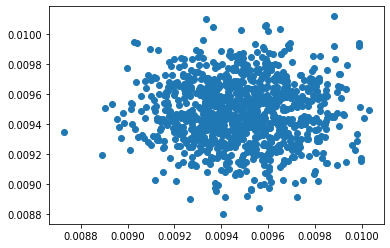

In [118]:
samples = base_density.sample((1000,))
py = flow.reverse(samples).detach().numpy()
plt.scatter(py[:,0], py[:,1])

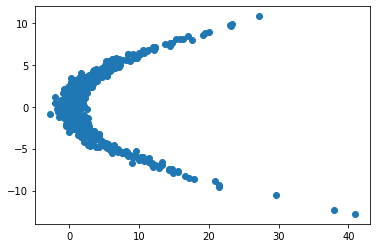

In [71]:
plt.scatter(boom_samples[:,0], boom_samples[:,1])

# Simple Test

In [40]:
y = base_density.sample((2,))
alpha = 2.0

I = torch.ones_like(y)
J_inv = torch.where(torch.greater_equal(y, 0), I, 1.0 / alpha * I)
# abs is actually redundant here, since this det Jacobian is > 0
log_abs_det_J_inv = torch.log(torch.abs(J_inv))
result = log_abs_det_J_inv.sum(axis=-1)

In [ ]:
a = AffineTrans()

y_to_x = a.inv(boom_samples)
log_prob_y_under_x = torch.sum(- (y_to_x ** 2) / 2 - np.log(np.sqrt(2 * np.pi)), -1)
a.inv.log_abs_det_jacobian(1,boom_samples).shape

boom_samples = sample_boom(1000)
flow(boom_samples)

In [ ]:
base_dist = distrib.Normal(0,1)
flow = distrib.TransformedDistribution(base_dist, [transform.AffineTransform(5,1)])

samples = base_dist.sample((10,))

loss = -flow.log_prob(samples).mean()

loss.backward()